# **1. Installation**

Please run the cell without modification

In [ ]:
!pip install pandas
!pip install pysam
!pip install numpy
!pip install biopython
!apt-get install bowtie
!apt-get install samtools

from google.colab import drive, files
from numpy import zeros
from Bio import SeqIO
import pandas as pd
import os, math, pysam, shutil, time, datetime

     |████████████████████████████████| 10.0MB 3.3MB/s 
     |████████████████████████████████| 2.3MB 4.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  bowtie-examples
The following NEW packages will be installed:
  bowtie
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,686 kB of archives.
After this operation, 7,343 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bowtie amd64 1.2.2+dfsg-2 [1,686 kB]
Fetched 1,686 kB in 2s (908 kB/s)
Selecting previously unselected package bowtie.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../bowtie_1.2.2+dfsg-2_amd64.deb ...
Unpacking bowtie (1.2.2+dfsg-2) ...
Setting up bowtie (1.2.2+dfsg-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Don

In [ ]:
#Function
def make_gff_from_ncbigb( file_gb, file_output, types = [ "CDS", "tRNA", "rRNA", "tmRNA", "misc_RNA" ] ):
    handle = open( file_gb, "r" )
    genomes = SeqIO.parse( handle, "gb" )    
    fout = open( file_output, "w" )

    for genome in genomes:  
        genome_id = genome.name
        print ( "genome id=" + genome_id, "length=" + str( len( genome ) ) )
        
        for f in genome.features:            
            if f.type in types :
                start = str( f.location.start.position )
                end = str( f.location.end.position )
                strand = f.strand
                try:
                    attr_gene = "/".join( [ q for q in f.qualifiers[ "gene" ] ] )            
                except:
                    attr_gene = ""
                try:
                    attr_locus_tag = f.qualifiers[ "locus_tag" ][ 0 ]
                except:
                    attr_locus_tag = ""

                if strand == 1:
                    strand = '+'
                else:
                    strand = '-'

                try:
                    attr_product = f.qualifiers[ "product" ][0]
                except:
                    attr_product = ""

                inner = "gene=" +  attr_gene + ";locus_tag=" + attr_locus_tag + ";type=" + f.type + ";product=" + attr_product 
                out = [ genome_id, "from_genbank", "gene_ncbi", start, end, ".", strand, ".", inner ]
                fout.write( "\t".join( out ) + "\n" )

    handle.close()
    fout.close()

def gb2fasta(file_gb, file_output) :
  handle = open( file_gb, "r" )
  genomes = SeqIO.parse( handle, "gb" )    
  fout = open( file_output, "w" )

  for genome in genomes:  
    fout.write( ">%s\n%s\n"%( genome.name, genome.seq ) )
  
  handle.close()
  fout.close()

def count_coverage(samfile, chromosome_size=6000000, flip=False):
    """counts coverage per base in a strand-specific manner

    For paired-end reads, the insert betwen the mapped reads is
    also counted.

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo

    chromsome_size: This value should be larger than the largest chromosome"""
    if samfile.has_index():
        return count_coverage_indexed(samfile, chromosome_size=chromosome_size, flip=flip)
    all_counts = {}
    plus_strands = []
    minus_strands = []
    if "SQ" in samfile.header:
        chromosome_sizes = {}
        for entry in samfile.header["SQ"]:
            chromosome_sizes[entry["SN"]] = int(entry["LN"]) + 1
    else:
        for reference in samfile.references:
            chromosome_sizes[reference] = chromosome_size
    for reference in samfile.references:  # create an array for each reference
        plus_strands.append(zeros((chromosome_sizes[reference],)))
        minus_strands.append(zeros((chromosome_sizes[reference],)))
    # iterate through each mapped read
    for i, read in enumerate(samfile):
        if read.is_unmapped:
            continue
        if not read.is_proper_pair:
            if read.is_reverse:
                minus_strands[read.tid][read.pos:read.aend] += 1
            else:
                plus_strands[read.tid][read.pos:read.aend] += 1
        # for paired-end data, get entire insert from only read1
        elif read.is_read1:
            if read.is_reverse:
                minus_strands[read.tid][read.pnext:read.aend] += 1
            else:
                plus_strands[read.tid][read.pos:read.pos + read.isize] += 1
    # store the results per reference
    for i, reference in enumerate(samfile.references):
        all_counts[reference] = {}
        if flip:
            all_counts[reference]["-"] = plus_strands[i]
            all_counts[reference]["+"] = minus_strands[i]
        else:
            all_counts[reference]["+"] = plus_strands[i]
            all_counts[reference]["-"] = minus_strands[i]
    return all_counts

def count_coverage_indexed(samfile, chromosome_size=6000000, flip=False):
    """counts coverage per base in a strand-specific manner

    For paired-end reads, the insert betwen the mapped reads is
    also counted.

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo

    chromsome_size: This value should be larger than the largest chromosome"""
    if "SQ" in samfile.header:
        chromosome_sizes = {}
        for entry in samfile.header["SQ"]:
            chromosome_sizes[entry["SN"]] = int(entry["LN"]) + 1
    else:
        for reference in samfile.references:
            chromosome_sizes[reference] = chromosome_size
    all_counts = {}
    for reference in samfile.references:  # go through each chromosome
        plus_strand = zeros((chromosome_sizes[reference],))
        minus_strand = zeros((chromosome_sizes[reference],))
        # iterate through each mapped read
        for i, read in enumerate(samfile.fetch(reference=reference)):
            if not read.is_proper_pair:
                if read.is_reverse:
                    minus_strand[read.pos:read.aend] += 1
                else:
                    plus_strand[read.pos:read.aend] += 1
            # for paired-end data, get entire insert from only read1
            elif read.is_read1:
                if read.is_reverse:
                    minus_strand[read.pnext:read.aend] += 1
                else:
                    plus_strand[read.pos:read.pos + read.isize] += 1
            all_counts[reference] = {}
            if flip:
                all_counts[reference]["-"] = plus_strand
                all_counts[reference]["+"] = minus_strand
            else:
                all_counts[reference]["+"] = plus_strand
                all_counts[reference]["-"] = minus_strand
    return all_counts


def write_samfile_to_gff(samfile, output, chromosome_size=6000000,
                         separate_strand=True, flip=False, log_scale=False):
    """write samfile object to an output object in a gff format

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo

    chromsome_size: This value should be larger than the largest chromosome

    separate_strand: Whether the forward and reverse strands should be made
    into separate tracks (True) or the negative strand should be rendered
    as negative values (False)
    """
    all_counts = count_coverage(samfile, chromosome_size=chromosome_size,
                                flip=flip)

    name = os.path.split(samfile.filename)[1].decode()
    for reference in all_counts:
        for strand in all_counts[reference]:
            counts = all_counts[reference][strand]			
            for i in counts.nonzero()[0]:			
                if log_scale:
                    count = math.log(float(counts[i]), 2)
                else:
                  count = counts[i]
                if separate_strand:
                    output.write("%s\t\t%s\t%d\t%d\t%.2f\t%s\t.\t.\n" %
                        (reference, "%s_(%s)" % (name, strand), i, i,count, strand))
                else:
                    output.write("%s\t\t%s\t%d\t%d\t%.2f\t%s\t.\t.\n" %
                        (reference, name, i, i, count,strand))
						

def convert_samfile_to_gff(sam_filename, out_filename, chromosome_size=6000000,
                           separate_strand=True, flip=False, log_scale=False):
    """read in the a samfile from a path, and write it out to a gff filepath

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo.

    chromsome_size: This value should be larger than the largest chromosome.

    separate_strand: Whether the forward and reverse strands should be made
    into separate tracks (True) or the negative strand should be rendered
    as negative values (False)
    """
    samfile = pysam.Samfile(sam_filename)
    with open(out_filename, "w") as outfile:
        write_samfile_to_gff(samfile, outfile, chromosome_size=chromosome_size,
                             separate_strand=separate_strand, flip=flip, 
							 log_scale=log_scale)
    samfile.close()
    
print ("Success")

Success


# **2. Files Upload**

Files can be uploaded directly to Colab (see Method 1) or from Google Drive (see Method 2).

Sample files are provided [here](https://drive.google.com/drive/folders/1g8pfs5GPs1r1SDSx_4LfAmoM45iMIVbL?usp=sharing)

---
**Files to be uploaded**

>**1. Reference genome file**
>> Reference genome in Genbank format (.gb) from NCBI

>**2. Sequencing data file**
>> Compressed fastq files (.gz)

>**3. Datasheet.csv file**
>> This is a tab-separated file created by user according to the following template.

---

>Each row contains information of each sample.

>Information is entered in 4 columns:

>> **sample_id** : Create sample names that are easy to understand. Names of replicates should end with _1,_2, etc.

>> **R1, R2** : Sequencing file name (In case of single-end sequencing, R2 is not required)

>> **organism** : reference genome file name (.gb)

**Method 1 - Direct upload to Colab**

In [ ]:
#Uploading files to Colab
myfile = files.upload()

Saving NC_000913.gb to NC_000913.gb


**Method 2 - Upload files from Google Drive**

Before running the code, create a 'ChIP-exo' folder in Google Drive.
Please upload files to the folder.

In [ ]:
#Mount to Google Drive and import files
drive.mount('/content/mnt/')

Mounted at /content/mnt/


In [ ]:
cd /content/mnt/My Drive/ChIP-exo

/content/mnt/My Drive/ChIP-exo


# **3. Running ChEAP**

In [ ]:
!mkdir '0_raw' '1_reference' '2_alignment' '3_gff'
!mv ./*.gb ./1_reference/
!mv ./*.gz ./0_raw/

print ( "Make directory : Success")

Make directory : Success


In [ ]:
#Check the datasheet
datasheet = pd.read_csv('datasheet.csv')
datasheet

,sample_id,R1,R2,organism
0,MG1655_RpoN-1,MG1655-RpoN-1_R1.fastq.gz,MG1655-RpoN-1_R2.fastq.gz,NC_000913
1,MG1655_RpoN-2,MG1655-RpoN-2_R1.fastq.gz,MG1655-RpoN-2_R2.fastq.gz,NC_000913


In [ ]:
!apt-get install gcc g++ pkg-config wget
!gcc -v
!wget http://hannonlab.cshl.edu/fastx_toolkit/fastx_toolkit_0.0.13_binaries_Linux_2.6_amd64.tar.bz2
!tar -xjf fastx_toolkit_0.0.13_binaries_Linux_2.6_amd64.tar.bz2
!rm fastx_toolkit_0.0.13_binaries_Linux_2.6_amd64.tar.bz2
!chmod 755 ./bin/fastx_trimmer

print ( "Trimmer setting : Success")
print ( "==================================================" )


for i,row in datasheet.iterrows():
  start = time.time()
  print ( "%s processing..."%(row['sample_id']) )
  dir_gb = "./1_reference/%s.gb"%(row['organism'])
  dir_fasta = "./1_reference/%s.fasta"%(row['organism'])
  dir_ref = "./1_reference/%s"%(row['organism'])
  dir_refgff = "./3_gff/reference_%s.gff"%(row['organism'])
  dir_gff_output = "./3_gff/%s.gff"%(row['sample_id'])

  #Unzip gz file
  dir_R1 = './0_raw/%s'%(row['R1'])
  !gzip -d $dir_R1

  #trimming the read
  dir_r = './0_raw/%s'%(row['R1'].split(".gz")[0])
  dir_trim = './0_raw/trim_%s'%(row['R1'].split(".gz")[0])
  
  !./bin/fastx_trimmer -l 31 -Q 33 -i $dir_r -o $dir_trim
  print ("Trimming is done")

  #build reference gff
  if os.path.isfile( dir_refgff ) :
    print ( 'Reference for bowtie already exist : %s'%(row['organism']))
  else:
    make_gff_from_ncbigb( dir_gb, dir_refgff )
    print ( 'Making reference gff : %s'%(row['organism']))

  #build reference file
  if os.path.isfile( dir_fasta ) :
    print ( 'Reference %s.gff already exist'%(row['organism']))
  else:
    gb2fasta( dir_gb, dir_fasta )
    !bowtie-build $dir_fasta $dir_ref
  
  #bowtie alignment
  bowtie_option = '-S'
  bowtie_output = "./2_alignment/%s.sam"%(row['sample_id'])
  bowtie_unaligned = bowtie_output + "_unaligned.fastq"
  
  print ("Mapping result:")

  !bowtie $bowtie_option $dir_ref $dir_trim --un $bowtie_unaligned > $bowtie_output
  print ("Bowtie running is done")

  #samtools
  sam_bam_unsorted = bowtie_output + ".unsorted.bam"
  sam_bam_sorted = "./2_alignment/%s.bam"%(row['sample_id']) 

  !samtools view -bS $bowtie_output -o $sam_bam_unsorted

  !samtools sort $sam_bam_unsorted -o $sam_bam_sorted
  !rm $sam_bam_unsorted

  !samtools index $sam_bam_sorted
  print ("Samtools running is done")
  
  convert_samfile_to_gff( bowtie_output, dir_gff_output )
  print ("Making the gff file is done")

  sec = time.time() - start
  times = str(datetime.timedelta(seconds=sec)).split(".")[0]

  print ("Running time for %s : %s "%(row['sample_id'], times ) )
  print ( "==================================================" )
!rm -r ./bin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
gcc set to manually installed.
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Using built-in specs.
COLLECT_GCC=gcc
COLLECT_LTO_WRAPPER=/usr/lib/gcc/x86_64-linux-gnu/7/lto-wrapper
OFFLOAD_TARGET_NAMES=nvptx-none
OFFLOAD_TARGET_DEFAULT=1
Target: x86_64-linux-gnu
Configured with: ../src/configure -v --with-pkgversion='Ubuntu 7.5.0-3ubuntu1~18.04' --with-bugurl=file:///usr/share/doc/gcc-7/README.Bugs --enable-languages=c,ada,c++,go,brig,d,fortran,objc,obj-c++ --prefix=/usr --with-gcc-major-version-only --program-suffix=-7 --program-prefix=x86_64-linux-gnu- --enable-shared --enable-linker-build-id --libexecdir=/usr/lib --wit

#**4. Data Visualization** 

Visualize GFF files in the '3_gff' folder using [Metascope software](https://sites.google.com/view/systemskimlab/software)




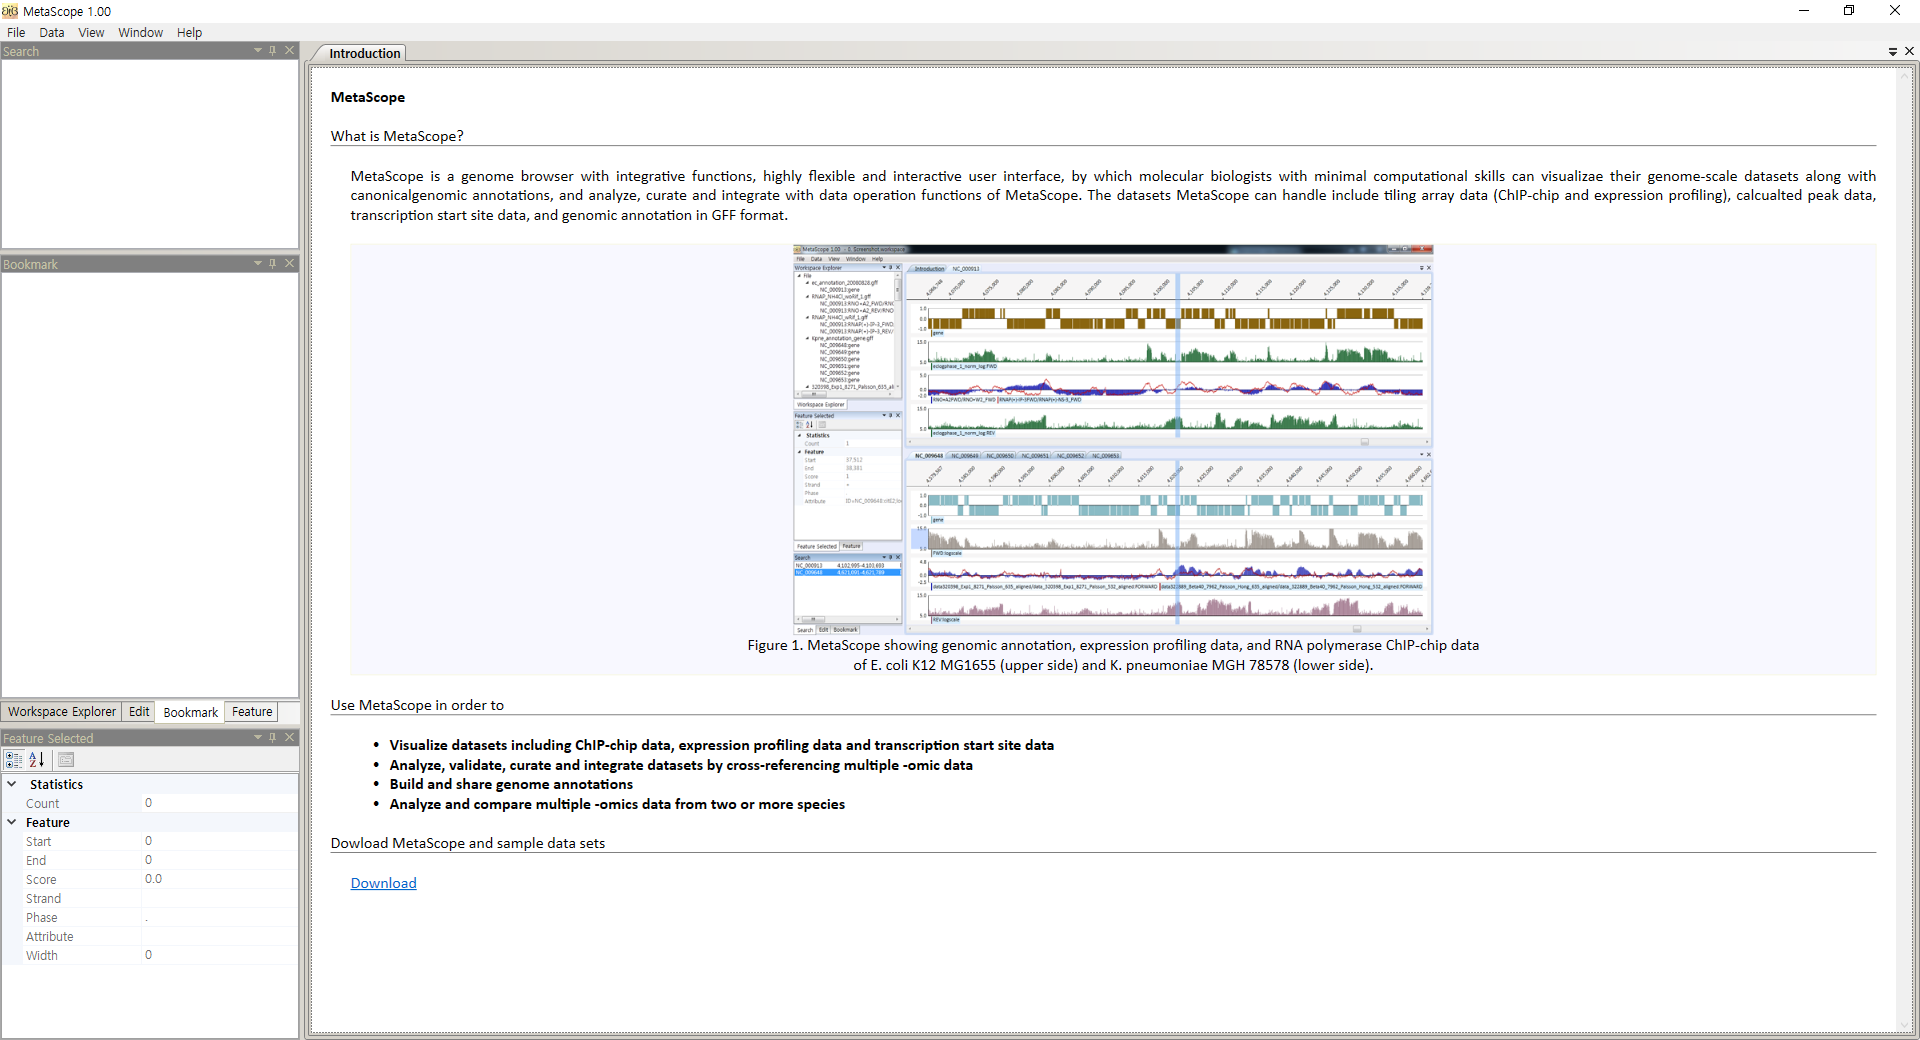